In [ ]:
"""
!pip install torch==1.4.0 torchvision==0.5.0
!pip install gym
!pip install gym[atari]
"""

In [ ]:
"""
from google.colab import drive
drive.mount('/content/drive/')

!cp "/content/drive/My Drive/Dissertation/preprocessing.py" .
!cp -r "/content/drive/My Drive/Dissertation/gym_maze" .
!cp -r "/content/drive/My Drive/Dissertation/envs" .
"""

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import gym
from preprocessing import AtariPreprocessing
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import cv2

from IPython import display
plt.ion()

# if gpu is to be used
device = torch.device("cpu")

In [2]:
FRAME_SKIP = 4

# resize to 84, make greyscale and scale observations from 0 to 1
env = AtariPreprocessing(gym.make('MontezumaRevengeNoFrameskip-v0'), frame_skip=FRAME_SKIP, screen_size=84, grayscale_newaxis=True, scale_obs=True)

---
### Helper functions

In [3]:
def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
    plt.pause(0.001)  # pause a bit so that plots are updated
    display.clear_output(wait=True)

In [4]:
def get_screen():   
    # transpose it into torch order (THW)
    screen = env._get_obs().transpose((2, 0, 1))
    screen = torch.from_numpy(screen)
    
    # add a batch dimension (BTHW)
    return screen.unsqueeze(0).to(device)

def get_screen_coloured():   
    # transpose it into torch order (TCHW)
    screen = env._get_obs_coloured()
    screen = screen.transpose((3, 2, 0, 1))
    screen = torch.from_numpy(screen)
    
    # add a batch dimension (BTCHW)
    return screen.unsqueeze(0).to(device)

In [5]:
def get_player_bounding_box():
    """
    output: (x, y, width, height)
    """
    screen = get_screen_coloured().cpu().squeeze(0)
    
    if np.count_nonzero(screen[3]) > 0:
        screen = screen[3].permute(1, 2, 0).numpy()
    else:
        # eg right after reset 
        screen = screen[0].permute(1, 2, 0).numpy()
    
    screen = np.asarray(screen * 255, dtype=np.uint8)
    
    hsv = cv2.cvtColor(screen, cv2.COLOR_RGB2HSV) 
      
    # lower mask (0-10)
    lower_red = np.array([0,50,50])
    upper_red = np.array([10,255,255])
    mask0 = cv2.inRange(hsv, lower_red, upper_red)

    # upper mask (170-180)
    lower_red = np.array([170,50,50])
    upper_red = np.array([180,255,255])
    mask1 = cv2.inRange(hsv, lower_red, upper_red)

    # join masks
    mask = mask0+mask1
    mask[0:25,:] = 0
    
    i, j = np.where(mask)
    
    # no player detected?
    if i.size == 0 or j.size == 0:
        return (0, 0, 1, 1)
    
    return (min(j) - 2, min(i) - 2, max(j) + 3 - (min(j) - 2), max(i) + 3 - (min(i) - 2))

# in form (x, y, width, height)
objs = {
    0: ( 16,  67, 11, 11),
    1: (133,  67, 11, 11),
    2: ( 74, 113, 11, 11),
    3: ( 19, 161, 11, 11),
    4: (130, 161, 11, 11),
    5: ( 11, 102, 11, 11)
}

def get_object_bounding_box(i):
    """
    6 "entities" as defined in the paper, also
    doubling up as the goals
        0: top-left door
        1: top-right door
        2: middle-ladder
        3: bottom-left-ladder
        4: bottom-right-ladder
        5: key
    bounding box checking is done in original screen space
    """
    return objs[i]

def get_screen_with_goal(i):
    o = np.array(get_object_bounding_box(i))
    screen = get_screen()
    
    # scale
    o[0] = np.ceil(o[0] * (84 / 160))
    o[2] = np.ceil(o[2] * (84 / 160))
    o[1] = np.ceil(o[1] * (84 / 210))
    o[3] = np.ceil(o[3] * (84 / 210))
    
    mask = np.zeros([84,84])
    mask[o[1]:(o[1] + o[3]),o[0]:(o[0] + o[2])] = 1
    mask = np.stack([mask]*4, 0)
    mask = torch.from_numpy(mask).unsqueeze(0).to(device)
    
    return np.maximum(screen, mask)

def goal_reached(i):
    """
    does simple AABB collision checking
    """
    p = get_player_bounding_box()
    o = get_object_bounding_box(i)
    if (o[0] >= p[0] + p[2]) or (o[0] + o[2] <= p[0]) or\
       (o[1] >= p[1] + p[3]) or (o[1] + o[3] <= p[1]):
            return False
    return True

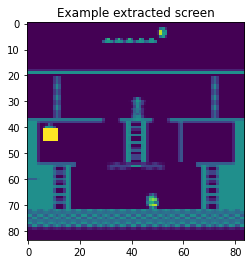

In [6]:
env.reset()
env.step(3)
plt.figure()
plt.imshow(np.average(get_screen_with_goal(5).cpu().squeeze(0).permute(1, 2, 0).numpy(), axis=2), interpolation='none')
plt.title('Example extracted screen')
plt.show()

---
### Code

In [202]:
# (state, action) -> (next_state, reward, done)
transition = namedtuple('transition', ('state', 'action', 'next_state', 'reward', 'done'))

# replay memory D with capacity N
class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    # implemented as a cyclical queue
    def store(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        
        self.memory[self.position] = transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [208]:
BATCH_SIZE = 128
GAMMA = 0.99

def one_hot(n, v):
    a = np.zeros(n)
    a[v] = 1.0
    return np.expand_dims(a, axis=0)

def rev_one_hot(a):
    return np.where(a[0] > 0)[0][0]

class DQN(nn.Module):
    def __init__(self, h, w, outputs, mem_len = 100000):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(FRAME_SKIP, 16, kernel_size=8, stride=4)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2)
        self.bn2 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size, stride):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        
        convw = conv2d_size_out(conv2d_size_out(w, 8, 4), 4, 2)
        convh = conv2d_size_out(conv2d_size_out(h, 8, 4), 4, 2)
        linear_input_size = convw * convh * 32
        
        self.fc = nn.Linear(linear_input_size, 256)
        self.head = nn.Linear(256, outputs)
        
        self.memory = ReplayMemory(mem_len)
        self.optimizer = None
        self.target = None # to keep parameters frozen while propogating losses
        
        self.n_actions = outputs
        self.steps_done = 0
        
        self.EPS_START = 0.9
        self.EPS_END = 0.05
        self.EPS_DECAY = 50000 # in number of steps

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.fc(x.view(x.size(0), -1)))
        return self.head(x)
    
    def act(self, state, step_size=1):
        eps_threshold = self.EPS_END + (self.EPS_START - self.EPS_END) * (1. - min(1., self.steps_done / self.EPS_DECAY))
        self.steps_done += step_size #FRAME_SKIP

        # With probability eps select a random action
        if random.random() < eps_threshold:
            return torch.tensor([[random.randrange(self.n_actions)]], device=device, dtype=torch.long)

        # otherwise select action = maxa Q∗(φ(st), a; θ)
        with torch.no_grad():
            return self(state).max(1)[1].view(1, 1)
    
    def experience_replay(self):
        if len(self.memory) < BATCH_SIZE:
            return
        
        # in the form (state, action) -> (next_state, reward, done)
        transitions = self.memory.sample(BATCH_SIZE)
        batch = transition(*zip(*transitions))
        
        state_batch = torch.cat(batch.state)
        next_state_batch = torch.cat(batch.next_state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        done_mask = np.array(batch.done)
        not_done_mask = torch.from_numpy(1 - done_mask).float().to(device)
        
        current_Q_values = self(state_batch).gather(1, action_batch)
        # Compute next Q value based on which goal gives max Q values
        # Detach variable from the current graph since we don't want gradients for next Q to propagated
        next_max_q = self.target(next_state_batch).detach().max(1)[0]
        next_Q_values = not_done_mask * next_max_q
        # Compute the target of the current Q values
        target_Q_values = reward_batch + (GAMMA * next_Q_values)
        # Compute Bellman error (using Huber loss)
        loss = F.smooth_l1_loss(current_Q_values, target_Q_values.unsqueeze(1))

        # Copy Q to target Q before updating parameters of Q
        self.target.load_state_dict(self.state_dict(), strict=False)
        
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.parameters():
            if param.grad is not None:
                param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

class HDQN(nn.Module):
    def __init__(self, h, w, outputs):
        super(HDQN, self).__init__()
        # Optimizer
        learning_rate = 2.5e-4
        
        # 6 goals, hard-coded
        self.meta_controller = DQN(h, w, 6, mem_len = 5000).to(device)
        self.meta_controller.optimizer = optim.RMSprop(self.meta_controller.parameters(), lr=learning_rate)
        self.meta_controller.target = DQN(h, w, 6, mem_len = 0).to(device)
        
        self.controller = DQN(h, w, outputs, mem_len = 50000).to(device)
        self.controller.optimizer = optim.RMSprop(self.controller.parameters(), lr=learning_rate)
        self.controller.target = DQN(h, w, outputs, mem_len = 0).to(device)
    
    def store_controller(self, *args):
        self.controller.memory.store(*args)
    
    def store_meta_controller(self, *args):
        self.meta_controller.memory.store(*args)
    
    def select_goal(self, external_observation):
        return self.meta_controller.act(external_observation)
        
    def select_action(self, joint_goal_obs):
        return self.controller.act(joint_goal_obs)
    
    def experience_replay(self):
        self.meta_controller.experience_replay()
        self.controller.experience_replay()

In [216]:
# Get number of actions and observations from gym action space
n_actions = env.action_space.n

init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

# Initialize action-value function Q with random weights
hdqnAgent = HDQN(screen_height, screen_width, n_actions).to(device)

num_episodes = 2000000 # M
episode_durations = []

for i_episode in range(num_episodes):
    env.reset()
    state = get_screen().float()
    
    overall_reward = 0
    done = False
    while not done:
        # select a goal
        goal = hdqnAgent.select_goal(state)
        goal_i = goal.item()
        
        goal_done = False
        total_extrinsic = 0
        s_0 = state
        while not done and not goal_done:
            joint_goal_state = get_screen_with_goal(goal_i).float()
            
            # uncomment to render
            #plt.figure()
            #plt.clf()
            #plt.imshow(np.average(joint_goal_state.cpu().squeeze(0).permute(1, 2, 0).numpy(), axis=2), interpolation='none')
            #plt.title('Example extracted screen')
            #plt.pause(0.001)
            #display.clear_output(wait=True)
            
            # Execute action a_t in emulator and observe reward r_t and image x_{t+1}
            action = hdqnAgent.select_action(joint_goal_state)
            
            old_lives = env.lives
            _, reward, done, _ = env.step(action.item())
            extrinsic_reward = torch.tensor([reward], device=device)
            
            overall_reward += reward
            total_extrinsic += reward

            # preprocess φ_{t+1} = φ(s_{t+1})
            next_state = get_screen().float()
            joint_next_state = get_screen_with_goal(goal_i).float()

            goal_done = goal_reached(goal_i)
            
            intrinsic_reward = torch.tensor([1.0 if goal_reached else 0.0], device=device)
                
            # Store transition (φt, at, rt, φt+1) in D
            hdqnAgent.store_controller(joint_goal_state, action, joint_next_state, intrinsic_reward, done)

            state = next_state

            hdqnAgent.experience_replay()
            
            if env.lives < old_lives:
                break
            
        # Store transition for meta controller
        hdqnAgent.store_meta_controller(s_0, goal, next_state, torch.tensor([total_extrinsic], device=device), done)
        hdqnAgent.experience_replay()
        
    episode_durations.append(overall_reward)
    plot_durations()

print('Complete')
plot_durations()

KeyboardInterrupt: 